In [1]:
import os
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix

## Loading Data

In [2]:
#Set training and test folder paths
training_path = 'features_train/features_train'
test_path = 'features_test/features_test'

#Load labels file
labels = pd.read_csv('labels.csv')

#Load feature description files, take out column 0 to use as header for training/test sets
features = pd.read_csv('feature_description.csv', encoding_errors='ignore', header=None, index_col=0)
features = features.index.tolist()

In [3]:
def load_data(folder_path):
    #Init empty dataframe
    res = pd.DataFrame()
    for file in os.listdir(folder_path):
        #for each speaker file
        if file.endswith('.csv'):
            #get participant id from filename, eg filename: 'spk_305.csv'
            participant = float(file.split('_')[1].split('.')[0])
            #find labels for the participant
            label = labels[labels['Participant_ID'] == participant]
            #load participant feature file
            file_path = os.path.join(folder_path, file)
            data_df = pd.read_csv(file_path, header=None, names=features)
            #Add labels and participant id columns
            data_df['participant'] = participant
            data_df['gender'] = label['Gender'].values[0]
            data_df['depression'] = label['Depression'].values[0]
            #combine everything to result
            res = pd.concat([res, data_df])
    return res

In [4]:
#Load training data
training_df = load_data(training_path)
len(training_df)

13626

In [5]:
#Load test data
test_df = load_data(test_path)
len(test_df)

3280

## Data cleaning and preprocessing 

In [6]:
# Check Missing values
missing_values = (training_df.isnull().sum()/len(training_df)) *100
total_missing_values = training_df.isnull().any(axis=1).sum()
print(f'Missing value percent % for each column, total samples {len(training_df)}')
print(f'Number of samples with missing values: {total_missing_values}')
print(missing_values)

Missing value percent % for each column, total samples 13626
Number of samples with missing values: 1
F0semitoneFrom27.5Hz_sma3nz_amean             0.007339
F0semitoneFrom27.5Hz_sma3nz_stddevNorm        0.007339
F0semitoneFrom27.5Hz_sma3nz_percentile20.0    0.007339
F0semitoneFrom27.5Hz_sma3nz_percentile50.0    0.007339
F0semitoneFrom27.5Hz_sma3nz_percentile80.0    0.007339
                                                ...   
StddevUnvoicedSegmentLength                   0.007339
equivalentSoundLevel_dBp                      0.007339
participant                                   0.000000
gender                                        0.000000
depression                                    0.000000
Length: 91, dtype: float64


In [7]:
def preprocess_data(data):
    #drop missing va;ues since there is just 1 sample
    data_nona = data.dropna()
    #Normalization z-score
    scaler = StandardScaler()    
    # Store the columns to keep for later concatenation
    columns_to_keep = ['participant', 'gender', 'depression']
    # Extract the columns to be scaled and drop them from the original DataFrame
    temp = data_nona[columns_to_keep].copy()
    data_nona.drop(columns=columns_to_keep, axis=1, inplace=True)
    # Scale the remaining columns using StandardScaler and convert back to DataFrame
    scaled_data = pd.DataFrame(scaler.fit_transform(data_nona), columns=data_nona.columns)
    scaled_data.reset_index(drop=True, inplace=True)
    temp.reset_index(drop=True, inplace=True)
    # Concatenate the scaled data with the columns we kept earlier
    processed_data = pd.concat([scaled_data, temp], axis=1)
    return processed_data

## Methods to calculate metrics

In [8]:
# Calculates accuracy
# pass true and predicted labels
# return accuracy score
def calculate_total_accuracy(true_labels, predicted_labels):
    return accuracy_score(true_labels, predicted_labels)

# Calculates accuracy
# pass true and predicted labels
# return balanced accuracy score
def calculate_balanced_accuracy(true_labels, predicted_labels):
    #calculkate confusion matrix
    matrix = confusion_matrix(true_labels, predicted_labels)
    TP = matrix[1, 1]
    TN = matrix[0, 0]
    FP = matrix[0, 1]
    FN = matrix[1, 0]
    #For positive class, how many correct predictions
    accuracy_positive = TP/(TP+FN)
    #For negative class how many 
    accuracy_negative = TN/(TN+FP)
    return 0.5*(accuracy_positive + accuracy_negative)

#Calculates Equality of Opportunity
# pass true and predicted labels for male samples
# pass true and predicted labels for female samples
# return balanced accuracy score
def calculate_EO(true_labels_male, 
                 true_labels_female,
                 predicted_labels_male,
                predicted_labels_female):
    #Calculate True pistive rate for male gender with confusion matrix
    matrix_male = confusion_matrix(true_labels_male, predicted_labels_male)
    TP = matrix_male[1, 1]
    TN = matrix_male[0, 0]
    FN = matrix_male[1, 0]
    TPR_male = TP/(TP+FN)

    #Calculate True pistive rate for female gender with confusion matrix
    matrix_female = confusion_matrix(true_labels_female, predicted_labels_female)
    TP = matrix_female[1, 1]
    TN = matrix_female[0, 0]
    FN = matrix_female[1, 0]
    TPR_female = TP/(TP+FN)
    
    # Calculate EO
    return 1-abs(TPR_male-TPR_female) 

#Function to calculate majority votings
#Pass labels
#Returns mode or which label was predicted most
def majority_voting(df):
    counts = df.value_counts()
    return counts.idxmax()

In [9]:
#Function to calculate all metrics
#Pass true labels, predicted labels and a reference(test/val) dataframe
#referece dataframe should have all labels and features
#Returns a dictionary with all the metric calculated
def calculate_metrics(y_true, y_pred, test_data):
    # Initialize metrics
    metrics = {}
    #---------------------------------------------------CALCULATING TOTAL METRICS
    #calculate total accuracy
    metrics["Total accuracy"] = calculate_total_accuracy(y_true, y_pred)
    #calculate total balanced accuracy
    metrics["Total Balanced accuracy"] = calculate_balanced_accuracy(y_true, y_pred)
    #calculate total EO
    #find gender based indices for true labels from data
    male_indices = test_data[test_data['gender']==1].index
    female_indices = test_data[test_data['gender']==0].index
    #separate true labels based on indices
    male_true = y_true.loc[male_indices]
    female_true = y_true.loc[female_indices]
    #Find the corresponding indices for predicted labels from true_labels
    male_true_index_list = male_true.index.tolist()
    female_true_index_list = female_true.index.tolist()
    #Get separated predicted labels based on gender
    male_predicted = y_pred[[male_true_index_list.index(index) for index in male_true_index_list]]
    female_predicted = y_pred[[female_true_index_list.index(index) for index in female_true_index_list]]
    metrics["Total EO"] = calculate_EO(male_true, female_true, male_predicted, female_predicted)
    #-------------------------------------------------CALCULATING AGGREGATED METRICS FOR EACH PARTICIPANT
    predictions_df = pd.DataFrame({'participant': test_data['participant'], 'predicted_label': y_pred, 'true_label': y_true})
    aggregated_y_true = predictions_df.groupby('participant')['true_label'].agg(majority_voting)
    aggregated_y_pred = predictions_df.groupby('participant')['predicted_label'].agg(majority_voting)
    #Calculate aggregated accuracy score
    metrics["Aggregated accuracy score"] = calculate_total_accuracy(aggregated_y_true, aggregated_y_pred)
    #Calculate balanced aggregated accuracy
    metrics["Aggregated balanced accuracy score"] = calculate_balanced_accuracy(aggregated_y_true, aggregated_y_pred)
    #Calculate aggregated EOs
    male_predictions_df = pd.DataFrame({'participant': test_data['participant'].loc[male_indices], 'predicted_label': y_pred, 'true_label': y_true})
    male_aggregated_y_true = male_predictions_df.groupby('participant')['true_label'].agg(majority_voting)
    male_aggregated_y_pred = male_predictions_df.groupby('participant')['predicted_label'].agg(majority_voting)
    female_predictions_df = pd.DataFrame({'participant': test_data['participant'].loc[female_indices], 'predicted_label': y_pred, 'true_label': y_true})
    female_aggregated_y_true = female_predictions_df.groupby('participant')['true_label'].agg(majority_voting)
    female_aggregated_y_pred = female_predictions_df.groupby('participant')['predicted_label'].agg(majority_voting)
    metrics["Aggregated EO score"] = calculate_EO(male_aggregated_y_true, female_aggregated_y_true, male_aggregated_y_pred, female_aggregated_y_pred)
    
    return metrics

## Data Modeling - Depression Classification
### What models to try?
- Decision tree
- Random forest
- TBD...........

### Model attempt: Decision tree classifier

In [10]:
#------------------------------------------------Tuning for different depths-------------------------------------------------------

warnings.filterwarnings("ignore")
training_data = preprocess_data(training_df)
X = training_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y = training_data['depression']

# Define the depths to experiment with
depths = [3, 5, 7, 9, 15, 30, 50, 70, 90]
# Initialize metrics
metrics = {}

# Perform cross-validation for each tree depth
for depth in depths:
    # Initialize decision tree model
    tree = DecisionTreeClassifier(max_depth=depth, criterion='entropy')
    # Cross validation k fold, 4:1::training:validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    #list to store metrics for each cross validation split
    fold_metrics = []

    # Perform cross-validation and collect metrics
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        #Fit the training set
        tree.fit(X_train, y_train)
        #Predict validation set
        y_pred = tree.predict(X_val)
        #calculate metrics
        fold_metrics.append(calculate_metrics(y_val, y_pred, training_data.iloc[val_index]))

    #find avg metrics for each depth
    metrics[depth] = {}
    sums = {}
    for metric in fold_metrics:
        for key, value in metric.items():
            sums[key] = sums.get(key, 0) + value
    for key in sums:
        sums[key]/=len(fold_metrics)
    metrics[depth] = sums

#Print metrics for all the hyperparameters (Depth)
for depth in metrics:
    print(f"for depth {depth}")
    print(metrics[depth])
    print()

for depth 3
{'Total accuracy': 0.7427522935779817, 'Total Balanced accuracy': 0.614146835015258, 'Total EO': 0.9211273979719625, 'Aggregated accuracy score': 0.7632183908045976, 'Aggregated balanced accuracy score': 0.6172619047619048, 'Aggregated EO score': 0.7166666666666667}

for depth 5
{'Total accuracy': 0.7558165137614679, 'Total Balanced accuracy': 0.6195597723853328, 'Total EO': 0.8949444103937563, 'Aggregated accuracy score': 0.7839080459770116, 'Aggregated balanced accuracy score': 0.6134920634920635, 'Aggregated EO score': 0.9333333333333332}

for depth 7
{'Total accuracy': 0.7664587155963303, 'Total Balanced accuracy': 0.6635276969963881, 'Total EO': 0.8656372218392292, 'Aggregated accuracy score': 0.8160919540229885, 'Aggregated balanced accuracy score': 0.679563492063492, 'Aggregated EO score': 0.85}

for depth 9
{'Total accuracy': 0.7719633027522935, 'Total Balanced accuracy': 0.6881463115118678, 'Total EO': 0.8813681999774786, 'Aggregated accuracy score': 0.841379310344

In [11]:
# ---------------------------------------------------------Testing for best depth----------------------------------------------------------------
test_data = preprocess_data(test_df)
training_data = preprocess_data(training_df)
X_train = training_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y_train = training_data['depression']
X_test = test_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y_test = test_data['depression']

best_depth = 70
# Initialize decision tree model
tree = DecisionTreeClassifier(max_depth=best_depth, criterion='entropy')
#Fit the training set
tree.fit(X_train, y_train)
#Predict for test set
y_pred = tree.predict(X_test)
#get metrics
metrics = calculate_metrics(y_test, y_pred, test_data)

print(metrics)

{'Total accuracy': 0.6859756097560976, 'Total Balanced accuracy': 0.5821532799493955, 'Total EO': 0.8045958851204269, 'Aggregated accuracy score': 0.7, 'Aggregated balanced accuracy score': 0.5476190476190477, 'Aggregated EO score': 0.8}


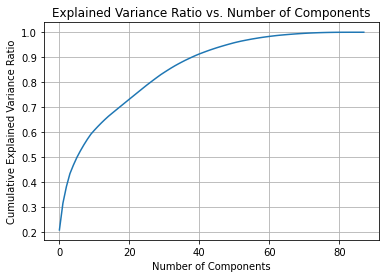

In [12]:
training_data = preprocess_data(training_df)
X = training_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y = training_data['depression']

# Initialize PCA with all components
pca = PCA(n_components=X.shape[1])

# Fit PCA to the data
pca.fit(X)

# Plot the explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

In [13]:
# Get feature importances
importances = tree.feature_importances_

importances_df = pd.DataFrame(importances, index=X_train.keys(), columns=["Importance"])
importances_df = importances_df.sort_values(by="Importance", ascending=False)
print(importances_df[0:10], end="\n\n")

                                            Importance
loudness_sma3_amean                           0.045927
F0semitoneFrom27.5Hz_sma3nz_percentile50.0    0.033857
spectralFlux_sma3_amean                       0.033542
logRelF0-H1-H2_sma3nz_amean                   0.027998
spectralFluxUV_sma3nz_amean                   0.025681
F0semitoneFrom27.5Hz_sma3nz_percentile20.0    0.025053
mfcc2V_sma3nz_amean                           0.024318
equivalentSoundLevel_dBp                      0.023095
mfcc4_sma3_amean                              0.020927
mfcc2_sma3_amean                              0.020733



In [14]:
# Apply SelectKBest with chi2
skb = SelectKBest(score_func=chi2, k=10)

print(X)

# X_new = skb.fit_transform(X, y)

# # Check which features were selected
# selected_features = skb.get_support()
# selected_features = X.keys()[selected_features]
# print(f"Selected features: ", selected_features)

       F0semitoneFrom27.5Hz_sma3nz_amean  \
0                               1.043703   
1                              -0.295361   
2                               0.117080   
3                              -3.301840   
4                               1.137499   
...                                  ...   
13620                          -0.196791   
13621                          -0.162972   
13622                          -0.345558   
13623                          -0.331947   
13624                           0.012836   

       F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
0                                    1.976252   
1                                   -1.093134   
2                                    0.330699   
3                                   -1.362988   
4                                   -1.257033   
...                                       ...   
13620                               -0.046297   
13621                               -0.610588   
13622                         

### Random Forest - Depression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

training_data = preprocess_data(training_df)
X = training_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y = training_data['depression']

# Define a list of different numbers of trees to experiment with
num_trees_list = [5, 10, 15, 20]

# Initialize list to store results
metrics_rf = {}

# Iterate over each number of trees
for num_trees in num_trees_list:
    print(num_trees)
    # Initialize model
    rf_model = RandomForestRegressor(n_estimators=num_trees, random_state=1)
    # Cross validation k fold, 4:1::training:validation
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    #list to store metrics for each cross validation split
    fold_metrics = []

    # Perform cross-validation and collect metrics
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        #Fit the training set
        rf_model.fit(X_train, y_train)
        #Predict validation set
        y_pred = rf_model.predict(X_val)
        y_pred = np.where(y_pred < 0.5, 0, 1)
        #calculate metrics
        fold_metrics.append(calculate_metrics(y_val, y_pred, training_data.iloc[val_index]))

    #find avg metrics for each depth
    metrics[num_trees] = {}
    sums = {}
    for metric in fold_metrics:
        for key, value in metric.items():
            sums[key] = sums.get(key, 0) + value
    for key in sums:
        sums[key]/=len(fold_metrics)
    metrics[num_trees] = sums

    
#Print metrics for all the hyperparameters (Depth)
for num_trees in metrics:
    print(f"for num_trees {num_trees}")
    print(metrics[num_trees])
    print()

5
10
15
20


In [23]:
# ---------------------------------------------------------Testing for best num_trees----------------------------------------------------------------
test_data = preprocess_data(test_df)
training_data = preprocess_data(training_df)
X_train = training_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y_train = training_data['depression']
X_test = test_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y_test = test_data['depression']

best_num_trees = 70
# Initialize decision tree model
rf_model = RandomForestRegressor(n_estimators=best_num_trees, random_state=1)
#Fit the training set
rf_model.fit(X_train, y_train)
#Predict for test set
y_pred = rf_model.predict(X_test)
#get metrics
metrics = calculate_metrics(y_test, y_pred, test_data)

print(metrics)

array([0.7, 0.8, 0.8, ..., 0. , 0. , 0. ])

In [31]:
print(y_pred[y_pred > 0.5].shape[0])
print(y_pred.shape[0])

3793
13625


### Random Forest - Gender

In [16]:
training_data = preprocess_data(training_df)
X = training_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y = training_data['gender']

# Define a list of different numbers of trees to experiment with
num_trees_list = [100, 250, 500, 1000]

# Initialize list to store results
avg_abs_errors_rf = []

# Iterate over each number of trees
for num_trees in num_trees_list:
    # Initialize model
    rf_model = RandomForestRegressor(n_estimators=num_trees, random_state=1)
    
    # Perform cross-validation and calculate the average absolute error
    avg_abs_error_rf = -cross_val_score(rf_model, X, y, cv=3, scoring='neg_mean_absolute_error').mean()
    avg_abs_errors_rf.append(avg_abs_error_rf)

# Print the average absolute errors for each number of trees
for num_trees, avg_abs_error_rf in zip(num_trees_list, avg_abs_errors_rf):
    print(f"Average Absolute Error with Number of Trees = {num_trees}: {avg_abs_error_rf}")